In [36]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [122]:
def fetch_pokemon_data(limit=1000):
    """
    Fetch Pokémon data from the PokéAPI.
    Args:
        limit (int): Number of Pokémon to fetch (default: 151 for the first generation).
    Returns:
        DataFrame: Pokémon data in a Pandas DataFrame.
    """
    base_url = "https://pokeapi.co/api/v2/pokemon"
    pokemon_data = []

    for i in range(1, limit + 1):
        response = requests.get(f"{base_url}/{i}")
        if response.status_code == 200:
            data = response.json()
            
            # Extract relevant fields
            pokemon = {
                "id": data["id"],
                "name": data["name"],
                "height": data["height"],
                "weight": data["weight"],
                "base_experience": data["base_experience"],
                "types": [t["type"]["name"] for t in data["types"]],
                "abilities": [a["ability"]["name"] for a in data["abilities"]],
                "stats": {s["stat"]["name"]: s["base_stat"] for s in data["stats"]},
            }
            pokemon_data.append(pokemon)
        else:
            print(f"Failed to fetch data for Pokémon ID: {i}")

    return pd.DataFrame(pokemon_data)


In [123]:
pokemon_df = fetch_pokemon_data()

In [124]:
# Normalize 'types' into separate columns
types_df = pokemon_df["types"].apply(pd.Series).rename(columns=lambda x: f"type_{x + 1}")
pokemon_df = pd.concat([pokemon_df, types_df], axis=1).drop(columns=["types"])

# Normalize 'abilities' into separate columns
abilities_df = pokemon_df["abilities"].apply(pd.Series).rename(columns=lambda x: f"ability_{x + 1}")
pokemon_df = pd.concat([pokemon_df, abilities_df], axis=1).drop(columns=["abilities"])

# Expand 'stats' into separate columns
stats_df = pokemon_df["stats"].apply(pd.Series)
pokemon_df = pd.concat([pokemon_df, stats_df], axis=1).drop(columns=["stats"])

# Check the transformed DataFrame
pokemon_df.head()

,id,name,height,weight,base_experience,type_1,type_2,ability_1,ability_2,ability_3,hp,attack,defense,special-attack,special-defense,speed
0,1,bulbasaur,7,69,64,grass,poison,overgrow,chlorophyll,NaN,45,49,49,65,65,45
1,2,ivysaur,10,130,142,grass,poison,overgrow,chlorophyll,NaN,60,62,63,80,80,60
2,3,venusaur,20,1000,263,grass,poison,overgrow,chlorophyll,NaN,80,82,83,100,100,80
3,4,charmander,6,85,62,fire,NaN,blaze,solar-power,NaN,39,52,43,60,50,65
4,5,charmeleon,11,190,142,fire,NaN,blaze,solar-power,NaN,58,64,58,80,65,80


In [125]:
# Save to CSV for reuse
pokemon_df.to_csv("pokemon_data.csv", index=False)

In [126]:
# Replace NaN values with "None" for categorical columns
pokemon_df.fillna({"type_2": "None", "ability_2": "None", "ability_3": "None"}, inplace=True)

In [127]:
# One-hot encode categorical columns
encoded_df = pd.get_dummies(pokemon_df, columns=["type_1", "type_2", "ability_1", "ability_2", "ability_3"])


In [128]:
from sklearn.preprocessing import MinMaxScaler

# Select numeric columns to normalize
numeric_cols = ["height", "weight", "base_experience", "hp", "attack", "defense", 
                "special-attack", "special-defense", "speed"]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
pokemon_df[numeric_cols] = scaler.fit_transform(pokemon_df[numeric_cols])


In [129]:
pokemon_df.columns

Index(['id', 'name', 'height', 'weight', 'base_experience', 'type_1', 'type_2',
       'ability_1', 'ability_2', 'ability_3', 'hp', 'attack', 'defense',
       'special-attack', 'special-defense', 'speed'],
      dtype='object')

In [130]:
pokemon_data = pokemon_df.copy()

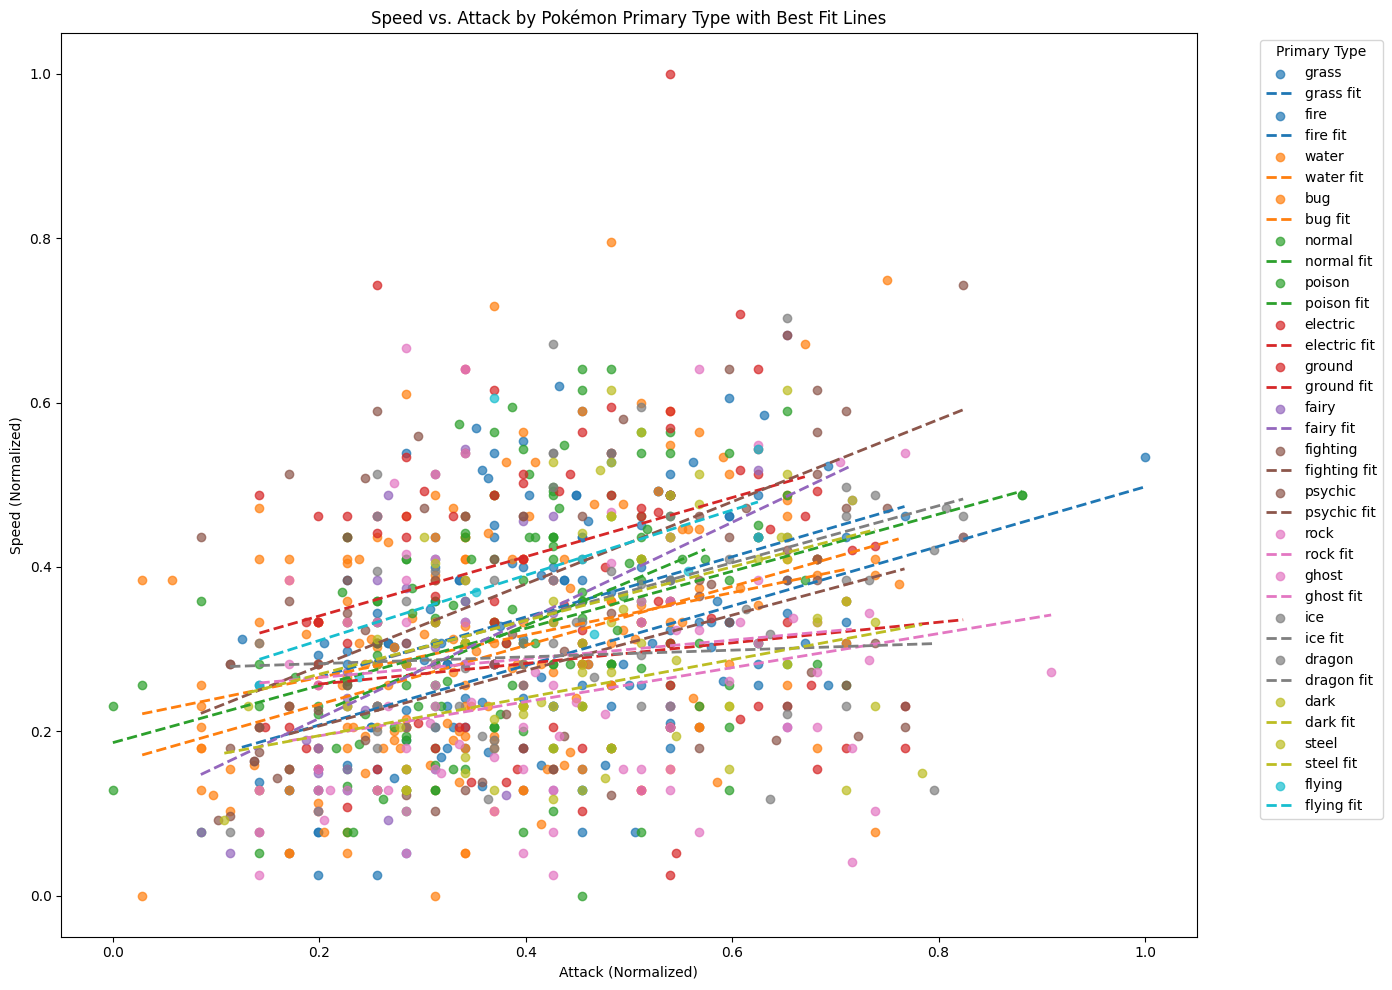

In [131]:
type_columns = [col for col in pokemon_data.columns if "type_1" in col]

if "type_1" in pokemon_data.columns:
    # Set up color mapping for primary types
    unique_types = pokemon_data["type_1"].unique()
    color_map = {ptype: plt.cm.tab10(i / len(unique_types)) for i, ptype in enumerate(unique_types)}

    # Create the scatter plot
    plt.figure(figsize=(14, 10))
    for p_type in unique_types:
        type_data = pokemon_data[pokemon_data["type_1"] == p_type]
        # Scatter plot for the current type
        plt.scatter(
            type_data["attack"],
            type_data["speed"],
            color=color_map[p_type],
            label=p_type,
            alpha=0.7
        )
        # Fit and plot regression line
        coefficients = np.polyfit(type_data["attack"], type_data["speed"], deg=1)
        poly_eq = np.poly1d(coefficients)
        x_vals = np.linspace(type_data["attack"].min(), type_data["attack"].max(), 100)
        plt.plot(
            x_vals,
            poly_eq(x_vals),
            color=color_map[p_type],
            linestyle="--",
            linewidth=2,
            label=f"{p_type} fit"
        )

    # Add titles and labels
    plt.title("Speed vs. Attack by Pokémon Primary Type with Best Fit Lines")
    plt.xlabel("Attack (Normalized)")
    plt.ylabel("Speed (Normalized)")
    plt.legend(title="Primary Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("The column 'type_1' does not exist in the dataset. Please check the data.")

In [132]:
if "type_1" in pokemon_data.columns:
    unique_types = pokemon_data["type_1"].unique()
    slopes = []

    for p_type in unique_types:
        # Filter data for the current type
        type_data = pokemon_data[pokemon_data["type_1"] == p_type]
        
        # Fit a line of best fit and extract the slope
        coefficients = np.polyfit(type_data["attack"], type_data["speed"], deg=1)
        slope = coefficients[0]  # The slope of the line
        slopes.append(slope)

        print(f"Type: {p_type}, Slope (Speed vs. Attack): {slope:.4f}")

    # Calculate the average slope
    average_slope = np.mean(slopes)
    print(f"\nAverage Relationship (Slope) between Speed and Attack for all Types: {average_slope:.4f}")
else:
    print("The column 'type_1' does not exist in the dataset. Please check the data.")

Type: grass, Slope (Speed vs. Attack): 0.3622
Type: fire, Slope (Speed vs. Attack): 0.3664
Type: water, Slope (Speed vs. Attack): 0.2579
Type: bug, Slope (Speed vs. Attack): 0.3588
Type: normal, Slope (Speed vs. Attack): 0.3475
Type: poison, Slope (Speed vs. Attack): 0.5320
Type: electric, Slope (Speed vs. Attack): 0.3601
Type: ground, Slope (Speed vs. Attack): 0.1255
Type: fairy, Slope (Speed vs. Attack): 0.5962
Type: fighting, Slope (Speed vs. Attack): 0.3371
Type: psychic, Slope (Speed vs. Attack): 0.5003
Type: rock, Slope (Speed vs. Attack): 0.2074
Type: ghost, Slope (Speed vs. Attack): 0.1140
Type: ice, Slope (Speed vs. Attack): 0.0409
Type: dragon, Slope (Speed vs. Attack): 0.3465
Type: dark, Slope (Speed vs. Attack): 0.3267
Type: steel, Slope (Speed vs. Attack): 0.2314
Type: flying, Slope (Speed vs. Attack): 0.3965

Average Relationship (Slope) between Speed and Attack for all Types: 0.3226


In [133]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [134]:
tf.keras.backend.clear_session()

In [135]:
# Select numeric columns for GAN modeling
numeric_cols = ["height", "weight", "base_experience", "hp", "attack", "defense", "special-attack", "special-defense", "speed"]
data = pokemon_data[numeric_cols].values

# Define GAN parameters
latent_dim = 10  # Dimension of the random noise vector
data_dim = data.shape[1]  # Number of numeric features
batch_size = 32
epochs = 1000

In [136]:
def build_generator():
    model = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(data_dim, activation='linear')  # Output layer matches the feature dimensions
    ])
    return model

# Build the Discriminator
def build_discriminator():
    model = Sequential([
        Dense(256, input_dim=data_dim),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')  # Output: probability of being real
    ])
    return model

# Initialize models
generator = build_generator()
discriminator = build_discriminator()

C:\Users\Vashist\PycharmProjects\Portfolio Projects\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Vashist\PycharmProjects\Portfolio Projects\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [137]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)


In [138]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [139]:
# Training loop with GradientTape
for epoch in range(epochs):
    # Generate random noise
    noise = tf.random.normal((batch_size, latent_dim))
    generated_data = generator(noise)

    # Select real data samples
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data = tf.convert_to_tensor(data[idx])

    # Labels for real and fake data
    real_labels = tf.ones((batch_size, 1))
    fake_labels = tf.zeros((batch_size, 1))

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_predictions = discriminator(real_data)
        fake_predictions = discriminator(generated_data)
        real_loss = loss_fn(real_labels, real_predictions)
        fake_loss = loss_fn(fake_labels, fake_predictions)
        d_loss = real_loss + fake_loss
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train Generator
    with tf.GradientTape() as tape:
        noise = tf.random.normal((batch_size, latent_dim))
        generated_data = generator(noise)
        predictions = discriminator(generated_data)
        g_loss = loss_fn(real_labels, predictions)  # Trick discriminator into thinking generated data is real
    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D loss = {d_loss.numpy()}, G loss = {g_loss.numpy()}")


Epoch 0: D loss = 1.3720941543579102, G loss = 0.7113707065582275
Epoch 100: D loss = 1.391571044921875, G loss = 0.6809476613998413
Epoch 200: D loss = 1.391136646270752, G loss = 0.660751223564148
Epoch 300: D loss = 1.3987247943878174, G loss = 0.6680047512054443
Epoch 400: D loss = 1.3852627277374268, G loss = 0.7258284091949463
Epoch 500: D loss = 1.389040470123291, G loss = 0.7089107632637024
Epoch 600: D loss = 1.3876752853393555, G loss = 0.7024717330932617
Epoch 700: D loss = 1.3936939239501953, G loss = 0.6877691149711609
Epoch 800: D loss = 1.3859935998916626, G loss = 0.6871860027313232
Epoch 900: D loss = 1.3863722085952759, G loss = 0.7121481895446777


In [140]:
# Generate New Pokémon Data
num_samples = 10
noise = tf.random.normal((num_samples, latent_dim))
generated_pokemon = generator(noise).numpy()

In [141]:
generated_pokemon_df = pd.DataFrame(generated_pokemon, columns=numeric_cols)
print("Generated Pokémon Stats:")
generated_pokemon_df

Generated Pokémon Stats:


,height,weight,base_experience,hp,attack,defense,special-attack,special-defense,speed
0,0.006330,0.007239,0.083547,0.283246,0.305303,0.194544,0.355477,0.138866,0.206804
1,0.051961,-0.043177,0.227884,0.312100,0.320978,0.220299,0.479540,0.277501,0.358222
2,0.037601,0.022338,0.059917,0.247572,0.181606,0.130891,0.251019,0.185182,0.103079
3,0.080320,0.061079,0.416378,0.398125,0.516970,0.315833,0.728638,0.410739,0.369543
4,0.022091,0.044770,0.154474,0.277202,0.303797,0.209670,0.348713,0.138577,0.104652
5,0.062665,-0.003602,0.229071,0.290567,0.186636,0.112614,0.590770,0.289273,0.393160
6,0.094147,0.042373,0.366618,0.474833,0.260109,0.123876,1.062342,0.458891,0.739862
7,0.008814,0.016146,0.075642,0.199734,0.144725,0.090950,0.167097,0.106932,0.165250
8,0.062041,0.243669,0.509602,0.565725,0.682376,0.472950,0.547073,0.416697,-0.011478
9,0.026929,0.038687,0.088083,0.340638,0.268886,0.245290,0.329173,0.240746,0.121737


In [142]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import numpy as np

# Extract Pokémon names
pokemon_names = pokemon_data['name'].str.lower().tolist()

# Tokenize characters
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(pokemon_names)

# Prepare sequences
sequences = []
for name in pokemon_names:
    tokenized_name = tokenizer.texts_to_sequences([name])[0]
    for i in range(1, len(tokenized_name)):
        sequences.append(tokenized_name[:i + 1])

# Pad sequences and create input-output pairs
max_seq_length = max(len(seq) for seq in sequences)
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='pre')
X_name = sequences[:, :-1]
y_name = to_categorical(sequences[:, -1], num_classes=len(tokenizer.word_index) + 1)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Build the name generator model
def build_name_generator():
    model = Sequential([
        Embedding(vocab_size, 50, input_length=max_seq_length - 1),
        LSTM(100),
        Dense(vocab_size, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# Initialize and train the name generator
name_generator = build_name_generator()
name_generator.fit(X_name, y_name, epochs=50, batch_size=32)

Epoch 1/50


C:\Users\Vashist\PycharmProjects\Portfolio Projects\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0722
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7460
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6549
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5904
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5655
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5418
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5317
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5119
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4730
Epoch 10/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4458
Epoch 11/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4152
Epoch 12/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4088
Epoch 13/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3630
Epoch 14/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3426
Epoch 15/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3263


In [144]:
import random

def generate_name_with_randomness(model, tokenizer, max_length, start_char='a', temperature=1.0):
    """
    Generate a name with variability using a temperature-scaled softmax.
    Args:
        model: Trained LSTM model for name generation.
        tokenizer: Character-level tokenizer.
        max_length: Maximum length of the name to generate.
        start_char: Starting character for the name.
        temperature: Controls randomness; lower values make predictions deterministic.
    Returns:
        str: Generated Pokémon name.
    """
    tokenized_start = tokenizer.texts_to_sequences([start_char])[0]
    name = tokenized_start
    for _ in range(max_length):
        padded_name = tf.keras.preprocessing.sequence.pad_sequences([name], maxlen=max_length, padding='pre')
        predictions = model.predict(padded_name)[0]
        # Apply temperature scaling to predictions
        predictions = np.log(predictions + 1e-9) / temperature
        probabilities = np.exp(predictions) / np.sum(np.exp(predictions))
        next_char = np.random.choice(len(probabilities), p=probabilities)
        if next_char == 0:  # End of name
            break
        name.append(next_char)
    return ''.join(tokenizer.sequences_to_texts([name])[0])

# Generate diverse names
generated_names = [generate_name_with_randomness(name_generator, tokenizer, max_seq_length, start_char=random.choice('abcdefghijklmnopqrstuvwxyz'), temperature=1.2) for _ in range(10)]
print("Generated Pokémon Names:", generated_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━

In [145]:
# Generate Pokémon stats using GAN
noise = tf.random.normal((10, latent_dim))
generated_stats = generator(noise).numpy()

# Combine stats with names
generated_pokemon_df = pd.DataFrame(generated_stats, columns=numeric_cols)
generated_pokemon_df['name'] = generated_names
print("Generated Pokémon with Stats and Names:")
generated_pokemon_df

Generated Pokémon with Stats and Names:


,height,weight,base_experience,hp,attack,defense,special-attack,special-defense,speed,name
0,0.108050,0.273457,0.274010,0.424041,0.491543,0.389545,0.362768,0.346996,0.141414,a m e t a r a d a s e - s t a d e d e - e r n ...
1,0.039807,0.134119,0.160593,0.262810,0.387825,0.320490,0.297820,0.231018,0.053901,l i g b e r - m i n e m e r r y p l t u r k i ...
2,0.031097,0.002669,0.103122,0.197540,0.162715,0.127759,0.295733,0.193885,0.251959,p r i m e a r t l e t h a r c e l - y d l y e ...
3,0.041967,-0.011042,0.184986,0.292862,0.267697,0.237472,0.406114,0.194604,0.217386,s e a n o m a d d o s s s i m n i n g r e f - ...
4,0.043983,0.001903,0.163572,0.271736,0.315213,0.177474,0.399971,0.236708,0.294221,d e l u m b r e g - t i o n a g e s s e e e r
5,0.017921,0.060704,0.162246,0.272059,0.317503,0.181289,0.427378,0.175699,0.237689,l a y f e y f l e y g y - m p l a n t t r o n ...
6,0.014926,-0.009508,0.148425,0.340539,0.286794,0.189301,0.497579,0.193405,0.263641,f a r i a k e e n - m a a n a i r a g e - l e ...
7,0.057769,-0.052921,0.099183,0.345880,0.351366,0.183124,0.456528,0.216638,0.349912,k r e g d i a n g l u f y - e t e l - f f e r ...
8,0.084530,0.066141,0.544671,0.413356,0.573824,0.396601,0.856499,0.399196,0.406585,x y p o p i k l e k i s e e m e r t e c r e p ...
9,0.030731,-0.018553,0.329724,0.322569,0.332416,0.263531,0.570322,0.300657,0.286770,g e l e c t r o m i n e - o n c r - m a t t e ...
